In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
chunk_size = 10000

In [4]:
tp_members = pd.read_csv('members.csv', iterator=True, chunksize=chunk_size)

df_members = pd.concat(list(tp_members), ignore_index=True)

In [5]:
tp_trans = pd.read_csv('transactions.csv', iterator=True, chunksize=chunk_size)

df_trans = pd.concat(list(tp_trans), ignore_index=True)

In [6]:
df_train = pd.read_csv('train.csv')

In [7]:
df_members = df_members[df_members['msno'].isin(df_train['msno'])]

In [8]:
df_trans = df_trans[df_trans['msno'].isin(df_train['msno'])]

In [9]:
df_members_train = pd.merge(df_members, df_train, on='msno', how='inner')

In [10]:
df_members_train.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,is_churn
0,75rp8sCaeatezkb6c0I133UakcSDuKcc5ia0b0Q+JS4=,1,24,male,3,20151129,20170925,1
1,1Nqjt8ykQceNOmuRrh9bcgvicDfLlj+jkgx7+Dd0Rk0=,1,0,NaN,7,20160410,20170909,0
2,gsDjjsDaM2cXEorLK8Qctgf6eO3NU1QgYK5q4j3dhfc=,1,0,NaN,7,20160608,20171007,0
3,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920,0
4,ZF5OFkIsel+d4VJ4uaOMjThPZRF6XRowQ9ZA/RCvBeY=,1,0,NaN,7,20160130,20171003,0


In [11]:
df_members_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876143 entries, 0 to 876142
Data columns (total 8 columns):
msno                      876143 non-null object
city                      876143 non-null int64
bd                        876143 non-null int64
gender                    396057 non-null object
registered_via            876143 non-null int64
registration_init_time    876143 non-null int64
expiration_date           876143 non-null int64
is_churn                  876143 non-null int64
dtypes: int64(6), object(2)
memory usage: 60.2+ MB


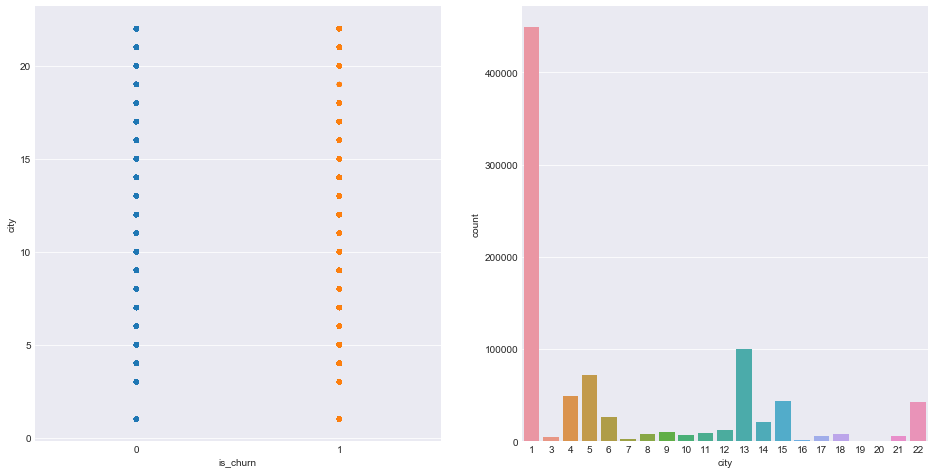

In [12]:
f,ax=plt.subplots(1,2,figsize=(16,8))
sns.stripplot(x="is_churn", y="city", data=df_members_train, ax=ax[0])
sns.countplot(x='city', data=df_members_train, ax=ax[1])

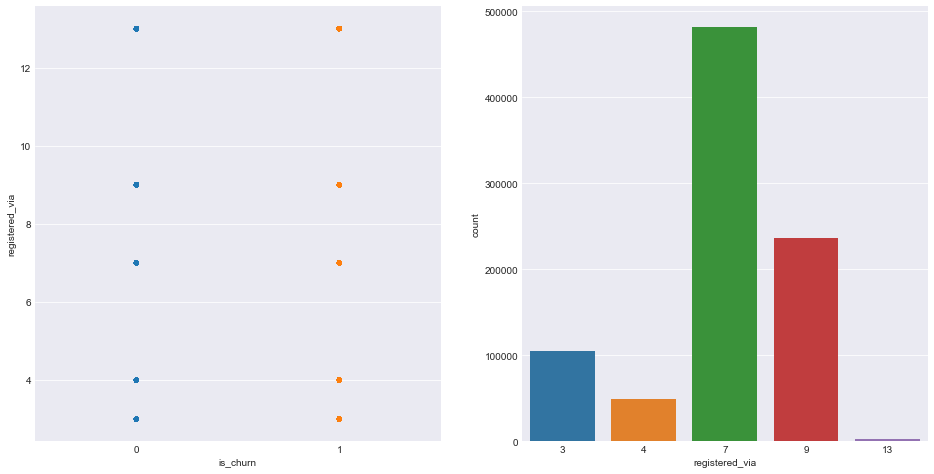

In [13]:
f,ax=plt.subplots(1,2,figsize=(16,8))
sns.stripplot(x="is_churn", y="registered_via", data=df_members_train, ax=ax[0])
sns.countplot(x='registered_via', data=df_members_train, ax=ax[1])

In [14]:
df_members_train['expiration_date'] = pd.to_datetime(df_members_train['expiration_date'],format='%Y%m%d')

In [15]:
df_members_train['registration_init_time'] = pd.to_datetime(df_members_train['registration_init_time'],format='%Y%m%d')

In [16]:
df_members_train['subscription_days'] = (df_members_train['expiration_date'] - df_members_train['registration_init_time']).dt.days

In [17]:
df_members_train.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,is_churn,subscription_days
0,75rp8sCaeatezkb6c0I133UakcSDuKcc5ia0b0Q+JS4=,1,24,male,3,2015-11-29,2017-09-25,1,666
1,1Nqjt8ykQceNOmuRrh9bcgvicDfLlj+jkgx7+Dd0Rk0=,1,0,NaN,7,2016-04-10,2017-09-09,0,517
2,gsDjjsDaM2cXEorLK8Qctgf6eO3NU1QgYK5q4j3dhfc=,1,0,NaN,7,2016-06-08,2017-10-07,0,486
3,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20,0,2223
4,ZF5OFkIsel+d4VJ4uaOMjThPZRF6XRowQ9ZA/RCvBeY=,1,0,NaN,7,2016-01-30,2017-10-03,0,612


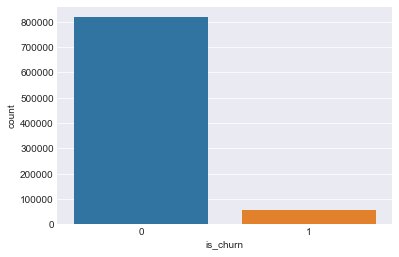

In [18]:
#sns.countplot(x='is_churn',data=df_members_train)

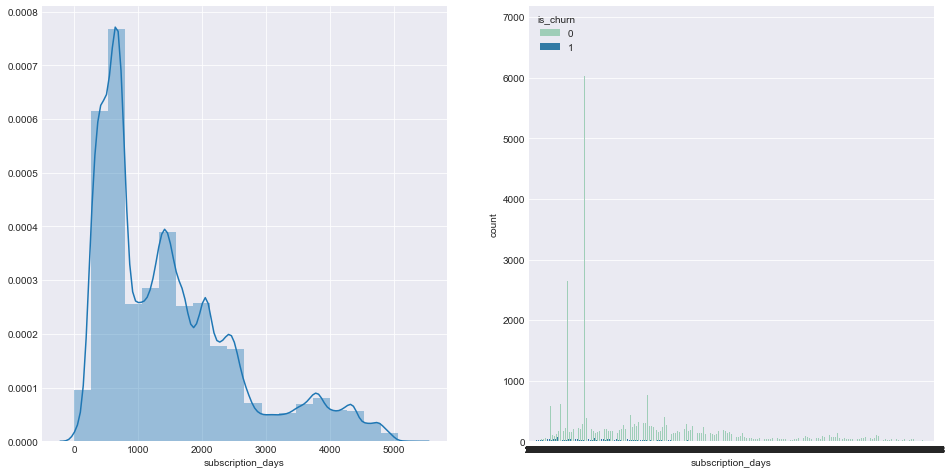

In [19]:
f,ax=plt.subplots(1,2,figsize=(16,8))
sns.distplot(df_members_train['subscription_days'], bins=20, ax=ax[0])
sns.countplot(x='subscription_days',data=df_members_train,hue='is_churn', palette='YlGnBu')

In [20]:
#sns.pairplot(df_members_train[['city','registered_via','is_churn','subscription_days']], hue='is_churn')

# Features engineering for transactions.csv

In [22]:
# drop rows that have no payments

df_trans_pay = df_trans.drop(df_trans[df_trans['actual_amount_paid'] <= 0].index)

In [23]:
# Format dates columns into datetime

df_trans_pay['transaction_date'] = pd.to_datetime(df_trans_pay['transaction_date'],format='%Y%m%d')
df_trans_pay['membership_expire_date'] = pd.to_datetime(df_trans_pay['membership_expire_date'],format='%Y%m%d')

In [24]:
# Re-calculate payment_plan_days if 0

df_trans_pay['payment_plan_days'] = np.where(df_trans_pay['payment_plan_days']==0,(df_trans_pay['membership_expire_date']-df_trans_pay['transaction_date']).dt.days,df_trans_pay['payment_plan_days'])

#Set payment_plan_days back to 0 if re-calculation is -ive

df_trans_pay.loc[df_trans_pay['payment_plan_days']<0,'payment_plan_days'] = 0

In [25]:
#a If plan_list_price is 0 assume it is actual_amount_paid

df_trans_pay.loc[df_trans_pay['plan_list_price']<=0,'plan_list_price'] = df_trans_pay['actual_amount_paid']

In [26]:
# Count # of payments

df_trans_pay['pay_count'] = df_trans_pay.groupby(df_trans_pay['msno'])['payment_method_id'].transform('count')

In [27]:
# Total subscription days

df_trans_pay['total_pay_days'] = df_trans_pay.groupby(df_trans_pay['msno'])['payment_plan_days'].transform('sum')

In [28]:
# Average payment in each transaction

df_trans_pay['avg_pay'] = df_trans_pay.groupby(df_trans_pay['msno'])['actual_amount_paid'].transform('mean')

In [29]:
# Total subscription payment

df_trans_pay['total_payments'] = df_trans_pay.groupby(df_trans_pay['msno'])['actual_amount_paid'].transform('sum')

In [30]:
# Assume is_cancel = 1 with actual payment > 0 is a plan change; count the total number of plan changes

df_trans_pay['count_plan_change'] = df_trans_pay.groupby(df_trans_pay['msno'])['is_cancel'].transform(lambda x: (x==1).sum())

In [31]:
# Count # of auto_renew

df_trans_pay['count_auto_renew'] = df_trans_pay.groupby(df_trans_pay['msno'])['is_auto_renew'].transform(lambda x: (x==1).sum())

In [32]:
# Average list Price

df_trans_pay['avg_list_price'] = df_trans_pay.groupby(df_trans_pay['msno'])['plan_list_price'].transform('mean')

In [33]:
df_trans_pay.drop_duplicates('msno',keep='last',inplace=True)

In [34]:
df_trans_pay_eda = df_trans_pay[['msno','pay_count','total_pay_days','avg_pay','total_payments','count_plan_change','count_auto_renew','avg_list_price']].reset_index()

In [35]:
df_trans_pay_eda.drop('index',axis=1, inplace=True)

In [36]:
df_trans_pay_eda.head()

,msno,pay_count,total_pay_days,avg_pay,total_payments,count_plan_change,count_auto_renew,avg_list_price
0,IjJ2K6chuC3uAgw/wjmsInpI/b2imM01D80cQHfN2wU=,1,410,1788.0,1788,0,0,1788.0
1,/IkS3fIO/BRhlMFFErSgrtpqzedcrwnW/FUbaB1E8JM=,1,410,1788.0,1788,0,0,1788.0
2,bwVRgPPJnJg62tVnHJWejdeavNP8DJQdBfrhzKm6Org=,1,30,149.0,149,0,0,149.0
3,CZ87lCEDKmbk7EXCy6Kh0zopNJxoEBTfWq9Eq9Az+28=,1,195,894.0,894,0,0,894.0
4,hCqnh1Sv8tXwSFHSw4ZGql6MwI31g+ahsszfmVTAE1g=,1,410,1788.0,1788,0,0,1788.0


In [37]:
df_merge = pd.merge(df_members_train, df_trans_pay_eda, on='msno', how='inner')

In [38]:
df_merge.shape

(874734, 16)

In [39]:
df_merge.drop(['gender','bd','registration_init_time','expiration_date'],axis=1,inplace=True)

In [40]:
df_merge.head()

,msno,city,registered_via,is_churn,subscription_days,pay_count,total_pay_days,avg_pay,total_payments,count_plan_change,count_auto_renew,avg_list_price
0,75rp8sCaeatezkb6c0I133UakcSDuKcc5ia0b0Q+JS4=,1,3,1,666,14,420,149.000000,2086,0,0,149.000000
1,1Nqjt8ykQceNOmuRrh9bcgvicDfLlj+jkgx7+Dd0Rk0=,1,7,0,517,11,330,99.000000,1089,0,11,99.000000
2,gsDjjsDaM2cXEorLK8Qctgf6eO3NU1QgYK5q4j3dhfc=,1,7,0,486,9,270,149.000000,1341,0,9,149.000000
3,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,7,0,2223,28,840,147.214286,4122,1,28,147.214286
4,ZF5OFkIsel+d4VJ4uaOMjThPZRF6XRowQ9ZA/RCvBeY=,1,7,0,612,11,330,108.090909,1189,1,11,108.090909


In [41]:
#sns.pairplot(df_merge.drop('msno',axis=1),hue='is_churn')

# Training the models

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X = df_merge.drop(['msno','is_churn'],axis=1)
y = df_merge['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# XGBoost with RandomizeSearchCV

In [ ]:
import scipy.stats as st
from xgboost import XGBClassifier

In [50]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
    'eval_metric': 'logloss'
}

xgb = XGBClassifier()

In [51]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgb, params, n_jobs=1)  
gs.fit(X_train, y_train)  

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x147c39da0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x147c54da0>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x147c63da0>, 'colsample_bytree': <scipy...147c28a20>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x147c28a20>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

# Prediction and Evaluations

In [52]:
predictions = gs.predict(X_test)

In [56]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss

In [54]:
print(confusion_matrix(y_test,predictions))

[[242921   2550]
 [ 10022   6928]]


In [55]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97    245471
          1       0.73      0.41      0.52     16950

avg / total       0.95      0.95      0.95    262421



In [57]:
print(log_loss(y_test,predictions))

1.65468287908


In [66]:
from xgboost import plot_importance

plot_importance(booster=gs.fit)

ValueError: tree must be Booster, XGBModel or dict instance